In [1]:
from lavis.datasets.builders import load_dataset
from lavis.models import load_model_and_preprocess
from dotenv import load_dotenv
from PIL import Image
from scipy.ndimage import binary_erosion
from typing import List, Tuple
from algo import (
    PITOME,
    TOME,
    DIFFRATE,
    DCT,
    TOFU,
    LTMP,
    NONE, 
    pitome,
    tome,
    DiffRate,
    tofu,
    # ltmp
)
import numpy as np
import torch
import torch.nn.functional as F


FLICKR_PATH='/media/caduser/MyBook/chau/.cache/flickr30k/images'
COCO_PATH='/media/caduser/MyBook/chau/.cache/coco/images'
dataset = load_dataset("coco_retrieval", vis_path=COCO_PATH, cfg_path=None)


Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_train.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_val.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/coco/annotations/coco_karpathy_test.json


In [2]:

from lavis.processors.base_processor import BaseProcessor
from lavis.processors.randaugment import RandomAugment
from omegaconf import OmegaConf
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from lavis.processors.blip_processors import BlipImageBaseProcessor

from main_vl import (
    PITOME,
    TOME, 
    TOFU, 
    DIFFRATE, 
)


In [3]:

def get_model(model, algo, ratio):
    if algo == PITOME:
        pitome.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        pitome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOME:
        tome.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        tome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOFU:
        tofu.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        tofu.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == DIFFRATE:
        DiffRate.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        DiffRate.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.init_kept_num_using_ratio(ratio)
        model.visual_encoder_m.init_kept_num_using_ratio(ratio)
    else:
        tome.patch.blip(model.visual_encoder,use_k=False, trace_source=True, output_attn=True)
        tome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True, output_attn=True)
        model.visual_encoder.ratio=1.0
        model.visual_encoder_m.ratio=1.0



In [4]:
class BlipImageEvalProcessor(BlipImageBaseProcessor):
    def __init__(self, image_size=384, mean=None, std=None):
        super().__init__(mean=mean, std=std)

      
        transform_list = [
            transforms.Resize(
                (image_size, image_size), interpolation=InterpolationMode.BICUBIC
            ),
        ]

        # The visualization and model need different transforms
        self.transform_vis  = transforms.Compose(transform_list)
        self.transform = transforms.Compose(transform_list + [
            transforms.ToTensor(),
            self.normalize,
        ])

    def __call__(self, item):
        return self.transform_vis(item), self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 384)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        return cls(image_size=image_size, mean=mean, std=std)

processor = BlipImageEvalProcessor() 


In [11]:



def generate_colormap(N: int, attention_score: torch.Tensor, seed: int = 0) -> List[Tuple[float, float, float]]:
  """
  Generates a colormap with N elements, with a bolder blue base and lightness adjusted based on attention scores.

  Args:
      N: Number of colors to generate.
      attention_score: A torch.Tensor representing the attention scores.
          This will be used to modulate the lightness of the blue color.
      seed: An optional integer seed for reproducibility.

  Returns:
      A list of tuples representing RGB color values (0.0 to 1.0).
  """



  def adjust_lightness(attention_value):
    normalized_attention = (attention_value - attention_score.min()) / (attention_score.max() - attention_score.min())
    # lightness_adjustment =  normalized_attention  # Adjust factor for lightness range
    base = (1.0, 1.0, 1.0)
    adjusted_color = [base[0]-2*normalized_attention, base[1]-2*normalized_attention, base[2]]
    return tuple(max(0.0, min(1.0, val)) for val in adjusted_color)

  colormap = [adjust_lightness(attention_value) for attention_value in attention_score.flatten().tolist()]

  return colormap


def make_visualization(
    img: Image, source: torch.Tensor, attention_score:torch.Tensor, patch_size: int = 16, class_token: bool = True
) -> Image:
    """
    Create a visualization like in the paper.

    Args:
     -

    Returns:
     - A PIL image the same size as the input.
    """

    img = np.array(img.convert("RGB")) / 255.0
    source = source.detach().cpu()

    h, w, _ = img.shape
    ph = h // patch_size
    pw = w // patch_size

    if class_token:
        source = source[:, :, 1:]
    vis = source.argmax(dim=1)
    num_groups = vis.max().item() + 1
    prune_mask = source.sum(dim=1)
    vis = vis * prune_mask
    num_groups = int(vis.max().item() + 1)       

    cmap = generate_colormap(num_groups, attention_score)
    vis_img = 0

    for i in range(num_groups):
        mask = (vis == i).float().view(1, 1, ph, pw)
        mask = F.interpolate(mask, size=(h, w), mode="nearest")
        mask = mask.view(h, w, 1).numpy()

        color = (mask * img).sum(axis=(0, 1)) / mask.sum()
        mask_eroded = binary_erosion(mask[..., 0])[..., None]
        mask_edge = mask - mask_eroded

        if not np.isfinite(color).all():
            color = np.zeros(3)

        vis_img = vis_img + mask_eroded * color.reshape(1, 1, 3)
        vis_img = vis_img + mask_edge * np.array(cmap[i]).reshape(1, 1, 3)

    # Convert back into a PIL image
    vis_img = Image.fromarray(np.uint8(vis_img * 255))

    return vis_img


In [12]:
def visualize(algo, index):
    model, _, _ = load_model_and_preprocess("blip_retrieval", "coco", is_eval=False)
    get_model(model,algo, 0.9)
    img = dataset['train'][index]['image']
    img_vis, img_input = processor(img)
    model.visual_encoder(img_input[None,...])
    if algo == TOME:
        source = model.visual_encoder._tome_info['source']
    elif algo == PITOME:
        source = model.visual_encoder._pitome_info['source']
    elif algo == TOFU:
        source = model.visual_encoder._tofu_info['source']
    elif algo == DIFFRATE:
        source = model.visual_encoder._diffrate_info['source']
    else: 
        source = model.visual_encoder._tome_info['source']
    attn = model.visual_encoder.blocks[-1].attn.attention_map
    return make_visualization(img_vis, source, attn.sum(1)[:, 0, :], patch_size=16, class_token=True)

using pitome
using pitome


/tmp/ipykernel_15836/1377820312.py:65: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


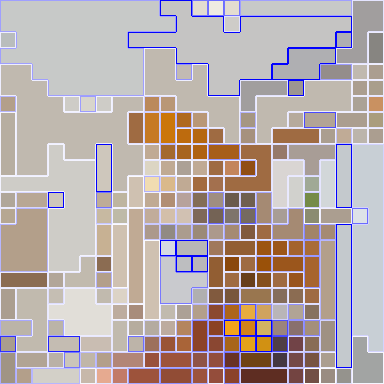

In [13]:
index = 79   
visualize(PITOME, index)

using tome
using tome


/tmp/ipykernel_15836/1377820312.py:65: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


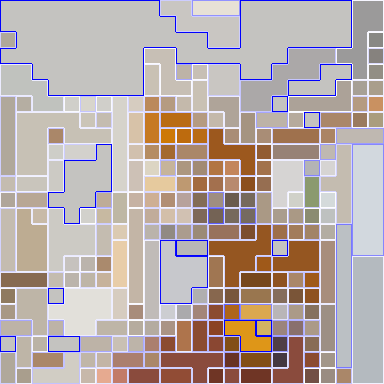

In [14]:
visualize(TOME, index)

using tofu
using tofu


/tmp/ipykernel_15836/1377820312.py:65: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


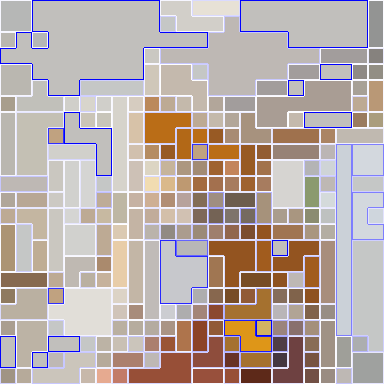

In [17]:
visualize(TOFU, index)

In [18]:
visualize(DIFFRATE, index)

TypeError: apply_patch() got an unexpected keyword argument 'use_k'

In [ ]:
visualize(NONE, index)